In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<ipython-input-3-cbe8f7c99398>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-3-cbe8f7c99398>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


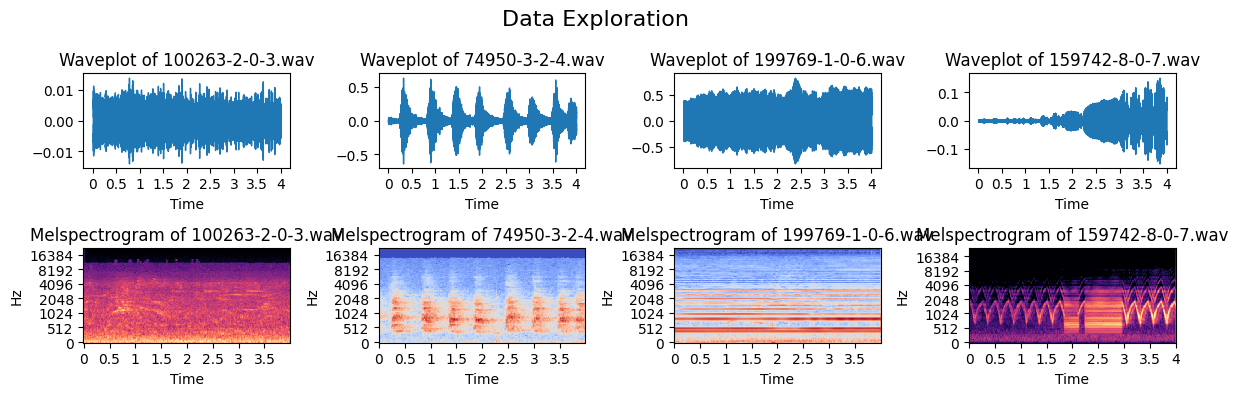

In [ ]:
visualize_class = ['children_playing', 'dog_bark', 'car_horn', 'siren']

description = pd.read_csv('/content/drive/MyDrive/project/UrbanSound8K.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_class)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(12, 4)
for i, digit in enumerate(visualize_class):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['class'] == digit]['slice_file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/project/rec', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_class)])
    axs[i+len(visualize_class)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [ ]:
import os
from tqdm import tqdm
import librosa
import numpy as np

feature_list = []
label_list = []

# Iterate over all files in the given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/project/rec')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/project/rec', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)

    # Ensure all mel spectrograms have the same number of columns (e.g., 87)
    max_columns = 87
    if mels_db.shape[1] < max_columns:
        # If fewer columns, pad with zeros
        mels_db = np.pad(mels_db, ((0, 0), (0, max_columns - mels_db.shape[1])))
    elif mels_db.shape[1] > max_columns:
        # If more columns, truncate
        mels_db = mels_db[:, :max_columns]

    # Reshape it according to the maximum number of columns
    feature_list.append(mels_db.reshape((128, -1, 1)))
    label_list.append(file[0])

features = np.array(feature_list)
labels = np.array(label_list)


Preparing feature dataset and labels.


100%|██████████| 8742/8742 [24:52<00:00,  5.86it/s]


In [ ]:
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import Input

# Assuming features has shape (batch_size, height, width, channels)
# If your features have a different shape, adjust accordingly.
# Load pre-trained DenseNet121 model with weights pre-trained on ImageNet
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 87, 3))  # Adjust the input shape to have 3 channels

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a custom top (classification) layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
print(model.summary())


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 87, 3)]         0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 93, 3)           0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 44, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

Epoch 1/10
67/67 [==============================] - 276s 4s/step - loss: 0.9942 - accuracy: 0.7004 - val_loss: 1.0230 - val_accuracy: 0.6879
Epoch 2/10
67/67 [==============================] - 222s 3s/step - loss: 0.8576 - accuracy: 0.7439 - val_loss: 0.9167 - val_accuracy: 0.7211
Epoch 3/10
67/67 [==============================] - 222s 3s/step - loss: 0.8072 - accuracy: 0.7537 - val_loss: 0.8588 - val_accuracy: 0.7495
Epoch 4/10
67/67 [==============================] - 203s 3s/step - loss: 0.7399 - accuracy: 0.7754 - val_loss: 0.8573 - val_accuracy: 0.7337
Epoch 5/10
67/67 [==============================] - 198s 3s/step - loss: 0.7488 - accuracy: 0.7712 - val_loss: 0.8126 - val_accuracy: 0.7587
Epoch 6/10
67/67 [==============================] - 222s 3s/step - loss: 0.6717 - accuracy: 0.7950 - val_loss: 0.7925 - val_accuracy: 0.7565
Epoch 7/10
67/67 [==============================] - 222s 3s/step - loss: 0.6374 - accuracy: 0.8076 - val_loss: 0.7421 - val_accuracy: 0.7919
Epoch 8/10
67

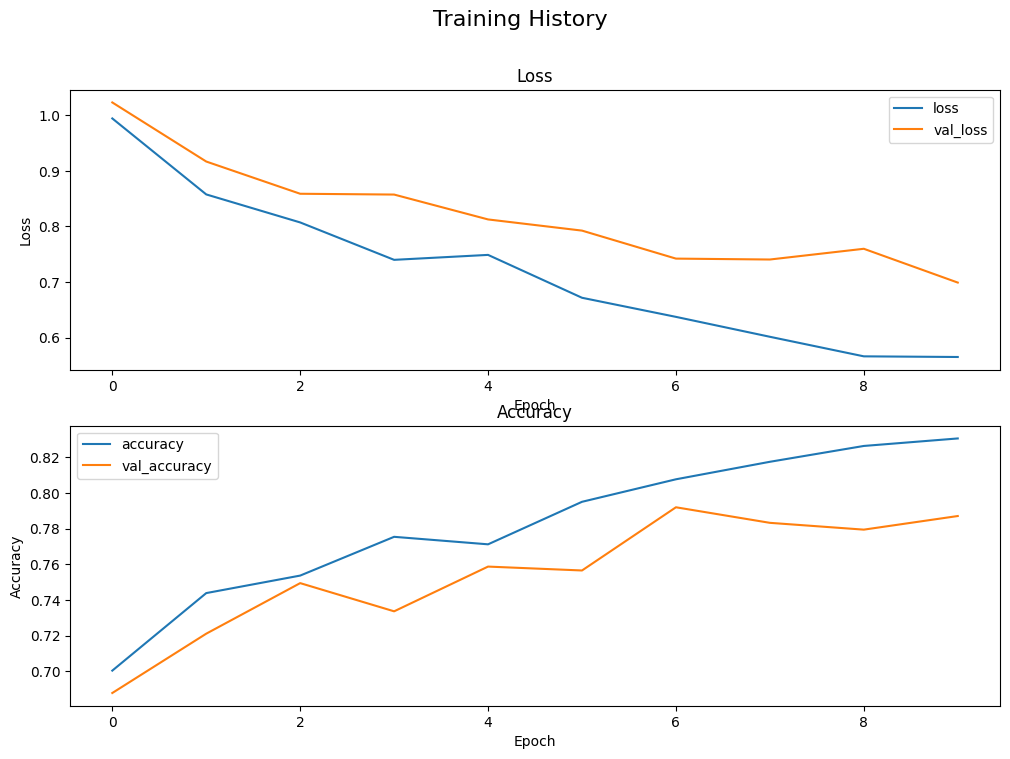

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 10

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)

# Expand the channel dimension to create RGB images
features_rgb = np.repeat(features, 3, axis=-1)

# Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features_rgb, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()


82/82 [==============================] - 85s 999ms/step


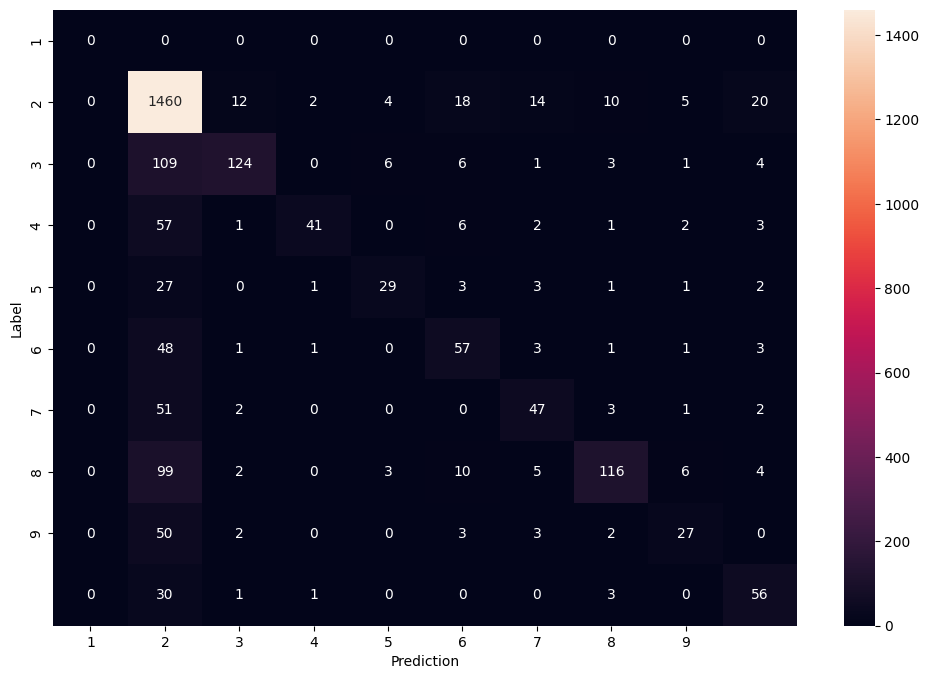

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()